## Linear regression: Ordinary least squares

In this notebook we will go over the concept of ordinary least squares estimation for linear regression.

In linear regression, we want to find the line:

$$
y = m*x + b
$$

that best relates two variables $x$ (the independent variable, or *predictor*) and $y$ (the dependent variable, or *outcome*).  We define "best" as the line that miminizes the squared error loss:

$$
L(y, \hat{y}) = \sum_{i=1}^N{(y_i - \hat{y})^2}
$$

where $\hat{y_i} = mx_i + b$.


In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats


Let's first look at a simple example, with two simulated variables that are linearly related.

In [61]:
np.random.seed(1)
npts = 20
noise_sd = 1
m = 0.5
b = 3
X = np.random.randn(npts, 1)
y = X.dot(m) + b + np.random.randn(npts, 1)*noise_sd


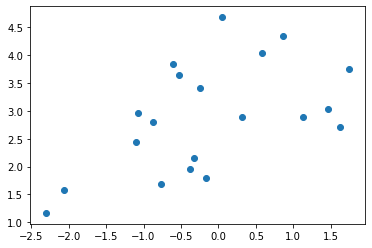

In [62]:
plt.scatter(X, y)

In [63]:
np.corrcoef(X[:,0], y[:,0])[0,1]

0.5351419257742921

## Estimating the regression solution using ordinary least squares

One way to understand the estimation of the best fitting line is through the relationship between the regression slope and the correlation coefficient.

Remember the formula for the Pearson correlation:

$$
r = \frac{covariance_{x,y}}{s_x * s_y} = \frac{\sum_{i=1}^N{(x_i - \bar{x})(y_i - \bar{y})}}{(N-1)*s_x*s_y}
$$

The estimate of the regression slope for a single independent variable is very similar:

$$
\hat{m} = \frac{covariance_{x,y}}{s^2_x}
$$

The only difference is that the correlation scales by the product of $s_x$ and $s_y$, whereas the regression slope scales only by the variance of the $x$ variable.  The relation between them is:

$$
\hat{m} = r * \frac{s_y}{s_x}
$$



Let's plot that line against our data:

(0.46289093635976236, 2.9492196505412007)

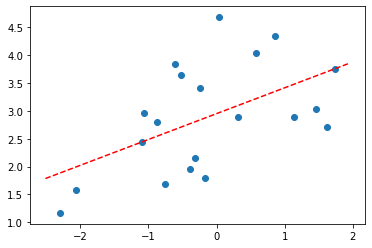

In [64]:
plt.scatter(X, y)

def abline(slope, intercept):
    """
    Plot a line from slope and intercept
    from: https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'r--')
    
m_hat = np.corrcoef(X.T, y.T)[0,1] * (np.std(y, ddof=1)/np.std(X, ddof=1))
intercept_hat = np.mean(y) - m_hat*np.mean(X)
abline(m_hat, intercept_hat)
m_hat, intercept_hat

## Solving OLS using linear algebra


In general, we would use linear algebra to estimate the OLS solution, because it is more flexible. Framed as a linear algebra problem:

$$
\textbf{Y} = \textbf{X} \cdot \textbf{b}
$$

The outcomes $\textbf{Y}$ and predictors $\textbf{X}$ are known, and we need to estimate the values of $\textbf{b}$ that result in the minimum squared error loss.

Conceptually, one might imagine solving for $\textbf{b}$ algebraically:

$$
\textbf{b} = \frac{\textbf{Y}}{\textbf{X}}
$$

However, since X is a matrix, we can't simply divide by it. However, another way to think about this is that we can multiply $\textbf{Y}$ by the matrix inverse of $\textbf{X}$:

$$
\textbf{b} = \textbf{X}^{-1} \cdot \textbf{Y}
$$

The problem here is that so far we only know how to compute the inverse of a square matrix, but $\textbf{X}$ is never going to be square (for reasons we will see later); it must always have more rows than columns.  In order to come up with $\textbf{X}^{-1}$, we need to use what is called the Moore-Penrose pseudoinverse, denoted $\textbf{X}^{+}$:

$$
\textbf{X}^{+} = (X^T \cdot X)^{-1} \cdot X^T
$$

for the particular case where $\textbf{X}$ has linearly independent columns and more rows than columns.  This produces a *left pseudoinverse*, meaning that if we want to multiply another vector by it, the pseudoinverse must be on the left.  We can now use this to generate the solution to our parameter estimation problem:

$$
\textbf{b} = (X^T \cdot X)^{-1} \cdot X^T \cdot \textbf{Y}
$$

Because $(X^T \cdot X)^{-1}$ is the covariance matrix of X, and $ X^T \cdot \textbf{Y}$ is the covariance between $\textbf{X}$ and $\textbf{y}$, we can view this as a multivariate generalization of the estimation formula above:

$$
\textbf{b} = \frac{cov(\textbf{X}, \textbf{Y})}{var(\textbf{X})}
$$



To estimate this, we need to allow the model to also estimate an intercept term.  This is basically a constant offset for all data points, so we can model this by adding a columns of ones to X:

In [65]:
# add an intercept term to X
X_int = np.hstack((X, np.ones((X.shape[0], 1))))

# estimate the parameters
b_hat = np.linalg.inv(X_int.T.dot(X_int)).dot(X_int.T).dot(y)

b_hat

array([[0.46289094],
       [2.94921965]])

We can also see the same result using the sklearn LinearRegression object.  This object by default automatically fits an intercept term, so we should turn that off since the intercept is already in our design matrix.

In [66]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(X_int,y)
lr.coef_

array([[0.46289094, 2.94921965]])

## Geometric view

We can also view least squares estimation in geometric terms.  If we view our data as a vector in an N-dimensional space (where each data point in the vector defines a different dimension), then we can view the job of linear regression as projecting that N-dimensional space into a new space that has the same number of dimensions as there are predictors in the model (i.e. the number of columns in the design matrix).

Let's first create a simple dataset, with three observations:


In [67]:
y = np.array([[3, 2, 2]]).T  # data to plot
y

array([[3],
       [2],
       [2]])

Now let's plot those data in a three-dimensional space.  We also show the two-dimensional space defined by our two basis vectors (in blue).

Text(0.5, 0, 'X1')

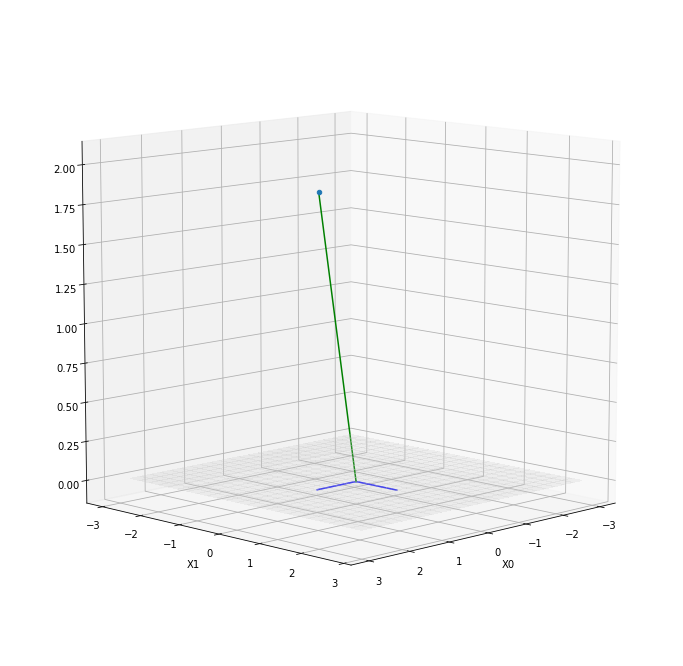

In [68]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')  # to work in 3d

# Make data for grid
Xgrid, Ygrid = np.meshgrid(np.arange(-3, 3, 0.25), np.arange(-3, 3, 0.25))
Zgrid = np.zeros(Xgrid.shape)

# Plot the surface.
ax.plot_surface(Xgrid, Ygrid, Zgrid, color='white',
                       linewidth=0, antialiased=False, alpha=0.2)

# set up variables for plotting
x = np.array([[1, 0, 0], [0, 1,0]]) # basis vectors

# plot basis vectors
for i in range(x.shape[0]):
    ax.plot3D([0, x[i, 0]], [0,x[i, 1]], [0, x[i, 2]], 'blue', )

# plot data vector
ax.plot3D([0, y[0, 0]], [0, y[1, 0]], [0, y[2, 0]], 'green',)
ax.scatter3D(y[0,0], y[1, 0], y[2, 0], cmap='Greens');

elev = 10
azim = 45
ax.view_init(elev, azim)  # set viewpoint
plt.xlabel('X0')
plt.ylabel('X1')

Now let's compute a least squares solution to project these data into our basis.  We will create a design matrix X with two columns; the two columns must be linearly independent, and each column should have a norm of one.

In [84]:
X = np.array([[1, 0], [0, 1], [1,1]])
# normalize
X = X / np.linalg.norm(X[:,0])

Now we use our formula from above to estimate $\hat{b}$ from the data:

In [85]:
bhat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(bhat)

[[2.82842712]
 [1.41421356]]


Now let's plot the estimated parameters in our space (the dotted black line):

Text(0.5, 0, 'X1')

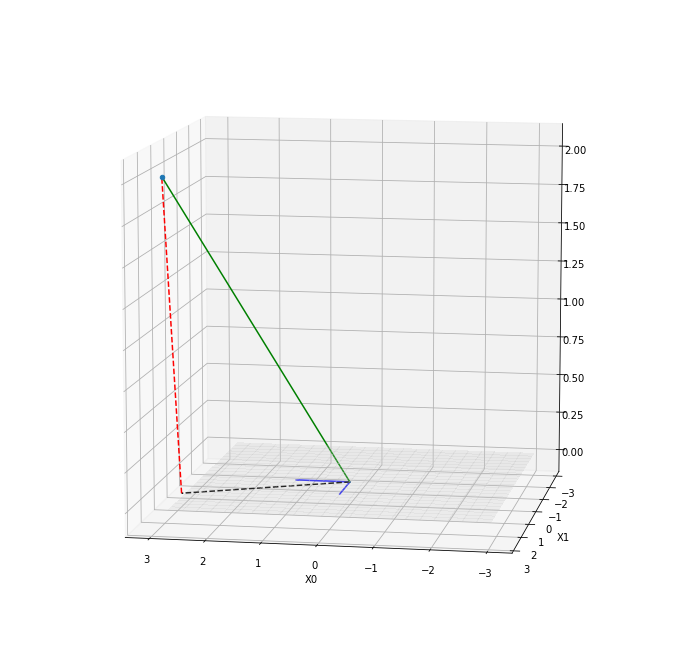

In [89]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')               # to work in 3d

# Plot the surface.
ax.plot_surface(Xgrid, Ygrid, Zgrid, color='white',
                       linewidth=0, antialiased=False, alpha=0.2)

# set up variables
y = np.array([[3, 2, 2]]).T
x = np.array([[1, 0, 0], [0, 1,0]])


# plot basis vectors
for i in range(x.shape[0]):
    ax.plot3D([0, x[i, 0]], [0,x[i, 1]], [0, x[i, 2]], 'blue', )

# plot data vector
ax.plot3D([0, y[0, 0]], [0, y[1, 0]], [0, y[2, 0]], 'green',)
ax.scatter3D(y[0,0], y[1, 0], y[2, 0], cmap='Greens');

# plot projection vector
ax.plot3D([0, bhat[0]], [0, bhat[1]], [0, 0], 'k--')

# plot error vector
ax.plot3D([bhat[0], y[0, 0]], [bhat[1], y[1, 0]], [0, y[2, 0]], 'r--')

ax.view_init(elev, azim) # set viewpoint
plt.xlabel('X0')
plt.ylabel('X1')


We now see that the original data vector (green line) has been decomposed into the projection into the column space of the design (black line), and the residual error (red line).  Let's confirm that the combination of the norms of these vectors (by the Pythagorean theorem) is the same as the norm of the original data.


In [13]:
norm_y = np.linalg.norm(y)
norm_y

4.123105625617661

In [14]:
norm_yhat = np.linalg.norm(X.dot(bhat))
norm_yhat

3.7416573867739413

In [15]:
resid = y - X.dot(bhat)
norm_resid = np.linalg.norm(resid)
norm_resid

1.7320508075688772

In [16]:
assert np.allclose(norm_y, np.sqrt(norm_yhat**2 + norm_resid**2))

## Fitting OLS to data

We can fit an OLS model to data using the `LinearRegression()` object from scikit-learn, which we have encountered before. Let's use the SRO dataset to assess the degree to which household income is predicted by fluid intelligence (as measured using the Raven's progressive matrices) and delay discounting (as measured using the Kirby intertemporal choice task).

In [17]:
def get_SRO_data(SRO_datadir = './data/SRO', vars = None):
    """
    load Eisenberg et al. dataset
    - by default, load the summary variables from meaningful_variables.csv 
    and the demographic/health data from demographics_health.csv
    
    vars: specific variables to return (if None, return all)
    """

    mvars = pd.read_csv(os.path.join(SRO_datadir, 'meaningful_variables.csv'), index_col=0)
    dvars = pd.read_csv(os.path.join(SRO_datadir, 'demographic_health.csv'), index_col=0)
    
    alldata = mvars.join(dvars)
    if vars is not None:
        assert isinstance(vars, list)
        alldata = alldata[vars]
    return(alldata)

SROdata = get_SRO_data(vars=['kirby.percent_patient', 'ravens.score', 'HouseholdIncome'])
# filter out zero income and unreasonably small values
SROdata = SROdata.query('HouseholdIncome>500')
SROdata.shape

(520, 3)

First let's fit a linear regression model, using the statstmodels `OLS()` function:

In [18]:
y = SROdata['HouseholdIncome'].copy()
X = SROdata[['kirby.percent_patient', 'ravens.score']].copy()
X['intercept'] = 1
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        HouseholdIncome   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     10.73
Date:                Wed, 01 Apr 2020   Prob (F-statistic):           2.72e-05
Time:                        15:24:05   Log-Likelihood:                -6107.3
No. Observations:                 520   AIC:                         1.222e+04
Df Residuals:                     517   BIC:                         1.223e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
kirby.percent_patient  2.039e+

This shows that both tasks are significantly associated with the outcome, though they account for a relatively small amount of variance (about 4%).  

## Regression diagnostics

It's always a good idea to make sure that the assumptions of our model are satisfied.  First, let's check whether the model is well specified, by plotting the residuals against both the X and Y variabes:

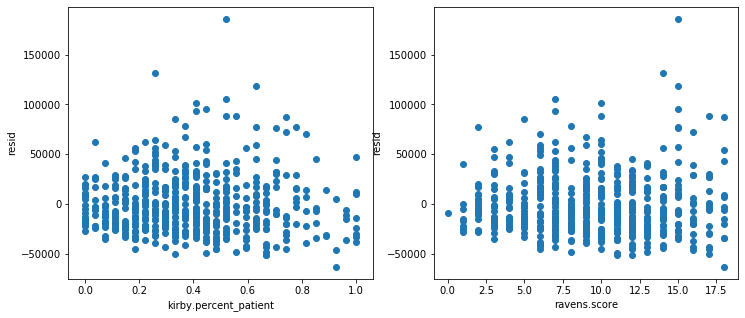

In [19]:
plt.figure(figsize=(12,5))
for i, col in enumerate(X.columns):
    if col == 'intercept':
        continue
    plt.subplot(1, 2, i+1)
    plt.scatter(X.loc[:, col], results.resid)
    plt.xlabel(col)
    plt.ylabel('resid')

There appear to be several outliers in the residual distribution.  We can also check for high-leverage points using a leverage plot provided by statsmodels:

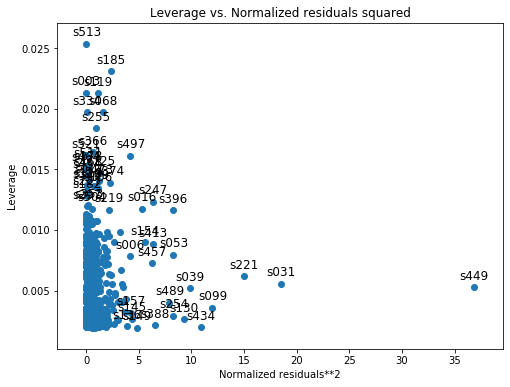

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(results, ax = ax)

Inference on the regression parameters requires the assumption that errors are normally distributed with constant variance.  The Jarque-Bera test reported in the statsmodels output is highly significant, suggesting that there is a lack of normality in the residuals. However, these kinds of tests for normality are often discouraged because they may be overly sensitive.  We can also visualize normality of residuals using a Q-Q plot:

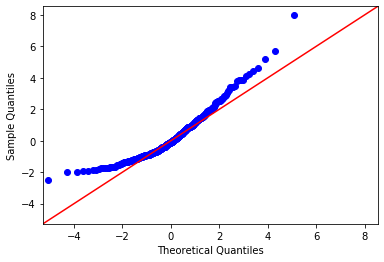

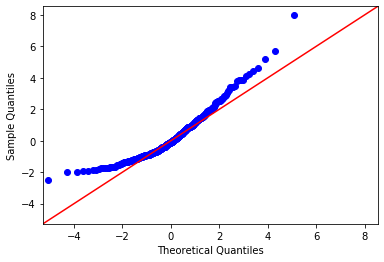

In [21]:
sm.qqplot(results.resid, scipy.stats.t, fit=True, line='45')

There seems to be a bit of skewness in the residuals. We would thus want to be careful about any inferences we make regarding this model.

## Collinearity in the design matrix

Collinearity does not affect the overall fit of the model, but it does affect the variance of the parameter estimates.  This is best seen through simulation.  Let's generate two regressors and an outcome based on the common variance:



In [22]:
n_subjects = 100
corr = 0.5
noise_sd = 1

corrvals = np.arange(0,1, 0.1)

beta = [3, -1, 0]
nruns = 100

scores = pd.DataFrame({'corr': np.zeros(nruns*len(corrvals)),
                      'beta1': np.zeros(nruns*len(corrvals)),
                      'beta2': np.zeros(nruns*len(corrvals)),
                      'intercept': np.zeros(nruns*len(corrvals)),
                      'score': np.zeros(nruns*len(corrvals)),
                      'VIF_beta1': np.zeros(nruns*len(corrvals))})

vif = pd.DataFrame({'VIF_beta1':np.zeros(len(corrvals))})

lr = LinearRegression(fit_intercept=False)
ctr=0
for i, corr in enumerate(corrvals):
    for j in range(nruns):
        X = np.random.multivariate_normal(mean=[0, 0],
            cov=[[1, corr], [corr, 1]], size=n_subjects)
        X = sm.add_constant(X)
        scores.loc[ctr, 'VIF_beta1'] = variance_inflation_factor(X, 1)
        
        y = X.dot(beta) + np.random.randn(X.shape[0])*noise_sd
        lr.fit(X, y)
        scores.loc[ctr, 'score'] = lr.score(X, y)
        scores.loc[ctr, 'corr'] = corr
        scores.loc[ctr, 'beta1'] = lr.coef_[1]
        ctr += 1
        

Now let's look at the parameter estimates for beta 1 and see how they relate to the actual value, as a function of the correlation between regressors.
    

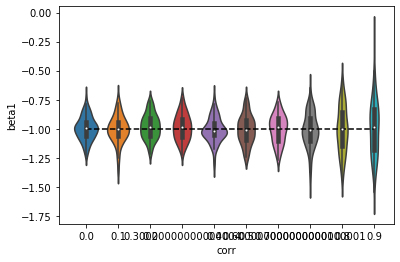

In [23]:
import seaborn as sns
sns.violinplot(x="corr", y="beta1",
               data=scores)
plt.plot([0, 9], [beta[1], beta[1]], 'k--')

Here we see that the correlation in the design matrix did not cause any bias, but it did increase the variability of the parameter estimates. This follows a specific pattern, known as the *variance inflation factor*:

$$ VIF = \frac{1}{(1 - R^2)} $$

Let's plot the observed variance against the variance that we would expect by applying the VIF to the observed variance for the uncorrelated case:

Text(0, 0.5, 'Variance in parameter estimates')

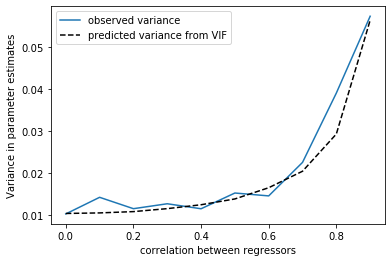

In [24]:
beta1_summary = scores[['corr', 'beta1', 'VIF_beta1']].groupby('corr').describe()
plt.plot(beta1_summary.index, beta1_summary.loc[:, ('beta1',   'std')]**2)

pred_std = (beta1_summary.loc[0, ('beta1',   'std')]**2) * beta1_summary.loc[:, ('VIF_beta1',   'mean')] 

plt.plot(beta1_summary.index, pred_std, 'k--')

plt.legend(['observed variance', 'predicted variance from VIF'])
plt.xlabel('correlation between regressors')
plt.ylabel('Variance in parameter estimates')

Here we see that the observed variance closely follows that predicted by the VIF.  

Importantly, the presence of correlations within the design matrix does *not* change the overall fit of the model, which we can see by plotting the distributions of fit scores for each level of correlation:

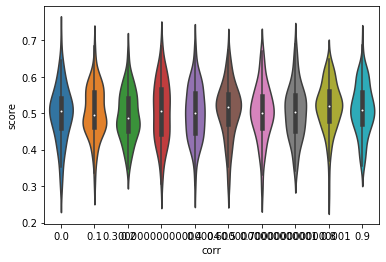

In [25]:
sns.violinplot(x="corr", y="score",
               data=scores)

## Effects of orthogonalization

In the analysis of neuroimaging data using general linear models (GLMs), it is often common to find that regressors of interest
are correlated with one another.  While this inflates the variance of the estimated parameters, the GLM ensures that the 
estimated parameters only reflect the unique variance associated with the particular regressor; any shared variance
between regressors, while accounted for in the total model variance, is not reflected in the individual parameter 
estimates.  In general, this is as it should be; when it is not possible to uniquely attribute variance to any
particular regressor, then it should be left out.  

Unfortunately, there is a tendency within the fMRI literature to overthrow this feature of the GLM by "orthogonalizing"
variables that are correlated.  This, in effect, assigns the shared variance to one of the correlated variables based 
on the experimenter's decision.  While statistically valid, this raises serious conceptual concerns about the 
interpretation of the resulting parameter estimates.

The first point to make is that, contrary to claims often seen in fMRI papers, the presence of correlated regressors
does not require the use of orthogonalization; in fact, in our opinion there are very few cases in which it is appropriate
to use orthogonalization, and its use will most often result in problematic conclusions.

*What is orthogonalization?*

As an example of how the GLM deals with correlated regressors and how this is affected by orthogonalization,
we first generate some synthetic data to work with.



In [26]:
npts = 100
corr = 0.5
X = np.random.multivariate_normal([0, 0], 
                                  [[1, corr],[corr, 1]], npts)
X = X - np.mean(X, 0)  # center variables

params = [1, 2]
y_noise = 0.2
Y = X.dot(params) + y_noise*np.random.randn(npts)

Plot the relation between each X variable and Y

correlation(X[0],Y)) 0.7506674295173121
correlation(X[1],Y)) 0.9347833645872778


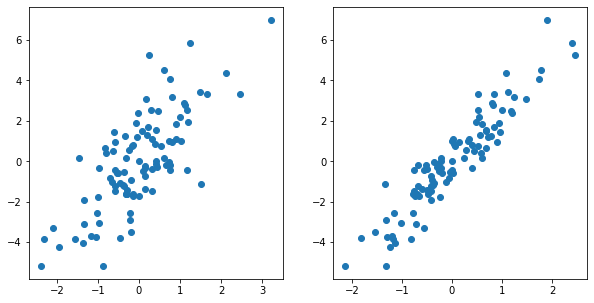

In [27]:
plt.figure(figsize=(10,5))
for i in range(2):
    print ('correlation(X[%d],Y))'%i, np.corrcoef(X[:,i],Y)[0,1])
    plt.subplot(1,2,i+1)
    plt.scatter(X[:,i],Y)

Now let's compute the parameters for the two columns in X using linear regression.  They should come out very close
to the values specified for params above.

In [28]:
# include rcond=None to suppress annoying warning
params_est =  np.linalg.lstsq(X,Y, rcond=None)[0]

print(params_est)

[0.98747884 2.00866935]


Now let's orthogonalize the second regressor (X1) with respect to the first (X0) and create a new orthogonalized design matrix X_orth. One way to do this is to fit a regression and then take the residuals.  We should see that the orthogonalized design matrix becomes uncorrelated.

In [29]:
x0_slope = np.linalg.lstsq(X[:, 0].reshape((npts, 1)), X[:, 1].reshape((npts, 1)), rcond=None)[0]

X_orth = X.copy()

X_orth[:, 1] = X[:, 1] - X[:, 0] * x0_slope

print('Correlation matrix for original design matrix')
print(np.corrcoef(X.T))

print('Correlation matrix for orthogonalized design matrix')
print(np.corrcoef(X_orth.T))


Correlation matrix for original design matrix
[[1.         0.47818319]
 [0.47818319 1.        ]]
Correlation matrix for orthogonalized design matrix
[[1.00000000e+00 3.27128796e-17]
 [3.27128796e-17 1.00000000e+00]]


Now let's look at the parameter estimates for the orthogonalized model:

In [30]:
params_est_orth =  np.linalg.lstsq(X_orth,Y, rcond=None)[0]

print(params_est_orth)

[1.88286932 2.00866935]


So what we see is that the parameter estimate for the orthogonalized regressor *did not change*!  Instead, the parameter estimate for the orthogonalized-against regressor changed, because all of the common variance is now being assigned to this regressor. Note that the interpretation of this effect is different than before: The effect for X0_orth is "the unique effect of X0 along with the common effect of X0 and X1".  One has to be very careful in using orthogonalization, and in general it is not a good idea ([Mumford et al., 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255)).

## Crossvalidation with regression

To assess the quality of the regression model, we can use cross-validation to assess out-of-sample fit.


In [31]:
from sklearn.metrics import r2_score
from get_balanced_folds import BalancedKFold


# set up SRO data from before:
# we don't need intercept column since it's fit by sklearn
y = SROdata['HouseholdIncome'].copy().values
X = SROdata[['kirby.percent_patient', 'ravens.score']].copy().values

kf = BalancedKFold(4)

predicted = np.zeros((X.shape[0], 1))
lr = LinearRegression()

for train_index, test_index in kf.split(X, y, seed=1):
    # create separate train and test datasets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # train the model
    lr.fit(X_train, y_train)
    predicted[test_index, 0] = lr.predict(X_test)



In [40]:
observed_r2 = r2_score(y, predicted)
observed_r2

0.03296213702278117

In order to assess the degree to which this value is greater than that expected by chance, we can use a randomization approach in which we repeatedly run this analysis, each time randomly shuffling the order of outcome variable. This breaks the relationship between X and y, essentially showing us the expected distribution under the null hypothesis of no relationship.  *NOTE*: This requires the assumption that rows in the dataset are exchangeable, which should be fulfilled when the individuals are random samples from a population. One would not want to use this for, e.g., timeseries data where the there are substantial correlations between subsequent rows.

In [38]:
# implement a function to run the CV once

def run_SRO_cv(X, y, score_fun=r2_score,
               seed = None, shuffle=False):
    kf = BalancedKFold(4)
    if shuffle:
        y = y.copy()
        np.random.shuffle(y)
    predicted = np.zeros((X.shape[0], 1))
    lr = LinearRegression()

    for train_index, test_index in kf.split(X, y, seed=seed):
        # create separate train and test datasets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # train the model
        lr.fit(X_train, y_train)
        predicted[test_index, 0] = lr.predict(X_test)

    return(r2_score(y, predicted))

run_SRO_cv(X, y, 1)

0.024261784070820247

Obtain the null distribution by repeatedly running this function with `shuffle=True`. Since we are looking at the tails, it's generally good to run a large number of randomizations, at least 2500.

In [39]:
nruns = 2500
r2_rand = np.zeros(nruns)

for i in range(nruns):
    
    r2_rand[i] = run_SRO_cv(X, y, 1, shuffle=True)

Find the proportion of randomization runs that have as large or larger $R^2$ as the observed data without shuffling:

In [43]:
pval = 1 - scipy.stats.percentileofscore(r2_rand, observed_r2)/100
pval

0.0

None of the randomization runs had an $R^2$ as large as or larger than our observed value, meaning that we can reject the null hypothesis of no predictive relationship.  We can see this by plotting the histogram of $R^2$ values from the randomization runs alongside the observed value:

Text(0, 0.5, 'Count')

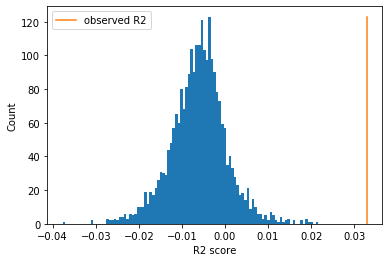

In [53]:
h = plt.hist(r2_rand, 100)
plt.plot([observed_r2, observed_r2], [0, max(h[0])])
plt.legend(['observed R2'])
plt.xlabel('R2 score')
plt.ylabel('Count')